In [ ]:
#imports
import tensorflow
import keras
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tqdm.notebook import tqdm as tqdm

In [ ]:
#Skripta za skidanje dataseta

#skidanje captioninga

#Dataset putanje
dataset_text = "Flickr_8k_text"
dataset_images = "Flicker8k_Dataset"


annotation_folder = '/Flickr_8k_text/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tensorflow.keras.utils.get_file('Flickr8k_text.zip',
                                          cache_subdir=os.path.abspath('.' + annotation_folder),
                                          origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/Flickr8k_text/Flickr8k_text.json'
  os.remove(annotation_zip)

#skidanje slika
image_folder = '/Flickr8k_Dataset/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tensorflow.keras.utils.get_file('Flickr8k_Dataset.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

1115422720/1115419746 [==============================] - 295s 0us/step


In [ ]:
#Uređivanje tekstualnih podataka
#Učitavanje datoteke u memoriju
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Riječnik koji spaja slike s njihovim opisima
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

#Pročiščavanje teksta, uklanjanje interpunckija i brojeva
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            desc = [word.lower() for word in desc]
            #ukloni interpunkciju
            desc = [word.translate(table) for word in desc]
            #uklanjanje  
            desc = [word for word in desc if(len(word)>1)]
            #uklanjanje brojeva
            desc = [word for word in desc if(word.isalpha())]

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

# Kreiranje vokabulara
def text_vocabulary(descriptions):
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

#Grupiranje svih opisa u jednu datoteku 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


filename = dataset_text + "/" + "Flickr8k.token.txt"
descriptions = all_img_captions(filename)
print("Broj opisa slika =" ,len(descriptions))

clean_descriptions = cleaning_text(descriptions)
vocabulary = text_vocabulary(clean_descriptions)
print("Broj rijeci u vokabularu = ", len(vocabulary))

#Spremanje opisa u zasebnu datoteku 
save_descriptions(clean_descriptions, "descriptions.txt")

Broj opisa slika = 8092
Broj rijeci u vokabularu =  8763


In [ ]:
#funkcija za izvlacenje značajki svih slika koja vrača vektor značajki s 2048 dimenzija
def extract_features(directory):
  #Koristimo model Inception V3 bez potpuno poveznaog zadnjeg sloja. Time dobivamo 1*1*2048 vektor značajki
        model = InceptionV3( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            #Normaliziramo vrijednosti pixela slike na između 1 i -1(0-255 u originalu)
            #image = image/127.5
            #image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

87916544/87910968 [==============================] - 2s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos


def load_clean_descriptions(filename, photos): 
    #Radimo rjecnik slike povezan s prociscenim opisima. Dodajemo pocetni i krajnji token kako bi mreza znala pocetak i kraj pojedinog opisa
    #i da imamo pocetno stanje
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

#Ucitavamo sve znacajke 
def load_features(photos):
    all_features = load(open("features.p","rb"))
    features = {k:all_features[k] for k in photos}
    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [ ]:
#Pretvaramo rjecnik u listu za tokenizaciju
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#Tokeniziramo sve opise  

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

#Najdulji opis slike
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)


#Spremamo u posebnu datoteku
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1


    
max_length = max_length(descriptions)
print('Vokabular= ' + str(vocab_size), 'Najdulji opis:' + str(max_length))

Vokabular= 7577 Najdulji opis:32


In [ ]:
#Koristimo generator jer ne mogu drzati sve feature zajedno sa slikama u radnoj memoriji 
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
      #za svaku sliku napravimo batch podataka
        for key, description_list in descriptions.items():
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [input_image, input_sequence], output_word

# Slijed koji sadrzi sliku, dosada vec predivdeni tekst koji vracamo natrag u model i sljedecu preidkciju rijeci  
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()

    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#Oblik inputa i outputa generatora
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

In [ ]:
from keras.utils import plot_model

# Definiranje modela neuralne mreze
def define_model(vocab_size, max_length):

    #Inception daje vektor velicine 2048
    inputs1 = Input(shape=(2048,))
    #Dropout sloj da bi sprijecili overfitting
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # Prikaz modela
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
#Treniranje mreže
print('Dataset: ', len(train_imgs))
print('Opisi: trening=', len(train_descriptions))
print('Slike: trening=', len(train_features))
print('Broj unikatnih riječi:', vocab_size)
print('Najdulji opis: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
os.mkdir("modeli")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("modeli/model_" + str(i) + ".h5")

Dataset:  6000
Opisi: trening= 6000
Slike: trening= 6000
Broj unikatnih riječi: 7577
Najdulji opis:  32
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 32, 256)      1939712     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]           




start dog is running through the grass end


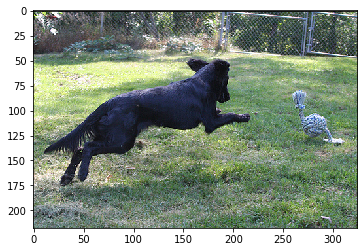




start dog is running through the water end


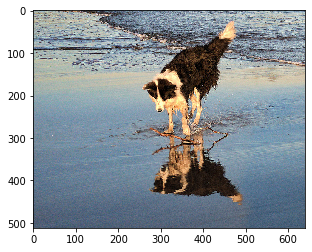




start man in red shirt is surfing end


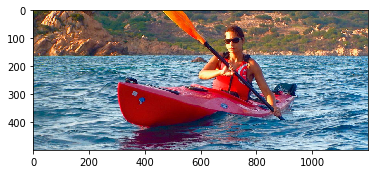




start man in red shirt is walking down the street end


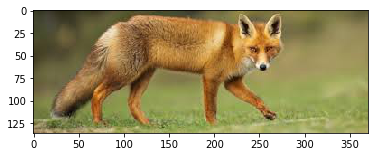




start man is standing on rocky terrain end


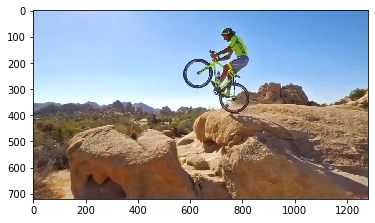




start man in red shirt is walking on the beach end


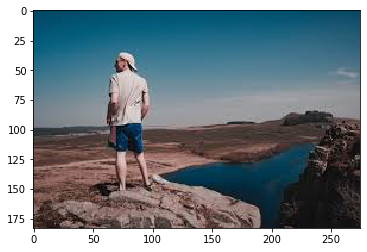




start man in wetsuit is in the water end


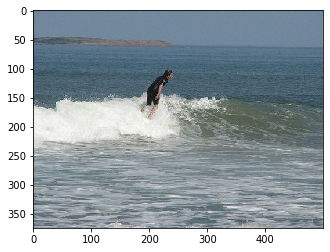




start man in red shirt is canoeing on the water end


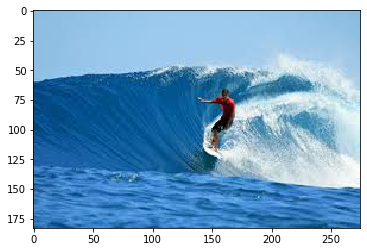




start man in red shirt is riding red horse end


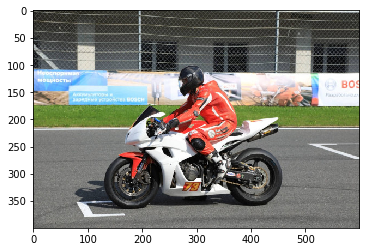

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

#Izvlacimo značajake samo jedne slike
def single_extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("Greška")
        image = image.resize((299,299))
        image = np.array(image)
        # Ako slika ima 4 channela prebacimo u 3
        if image.shape[2] == 4: 
            image = image[..., :3]
        #Dodajemo dimenziju jer Inception trazi array s 4 dimenzije 
        image = np.expand_dims(image, axis=0)
        #image = image/127.5
        #image = image - 1.0
        image = preprocess_input(image)
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
     if index == integer:
         return word
  return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
#print(tokenizer.word_index)
inception_model = InceptionV3(include_top=False, pooling="avg")
lista_slika=['dog.png','dogbeach.jpg','kayak.jpg','fox.jpg','bikestunt.jpg','manonrock.jpg','surfer.png','surfing.jpg','motor.jpg']
model = load_model('modeli/model_9.h5')
for slika in lista_slika:
    photo = single_extract_features(slika,inception_model)
    img = Image.open(slika)
    description = generate_desc(model, tokenizer, photo, max_length)
    print("\n\n")
    print(description)
    plt.imshow(img)
    plt.show()